# querying the data lake in a jupyter notebook

## prerequisites

make sure you have `pip install presto-python-client` and `pandas` and `matplotlib` installed.
you may do that via `pip install <name from above>`

In [1]:
import prestodb

In [2]:
conn=prestodb.dbapi.connect(
    host='presto.apps.eu.idealo.com',
    port=443, user='aishwarya.kumar',
    catalog='hive',
    http_scheme='https',
    schema='default',)

In [3]:
conn

## creating a cursor object instance

In [4]:
# create the cursor
cur = conn.cursor()
# cursor objects functions and attributes
[thing for thing in dir(cur) if '_' not in thing]

['arraysize',
 'cancel',
 'close',
 'connection',
 'description',
 'execute',
 'executemany',
 'fetchall',
 'fetchmany',
 'fetchone',
 'genall',
 'rowcount',
 'setinputsizes',
 'setoutputsize',
 'stats']

## exploring the schemas and tables

In [5]:
#schema either in double quotes or without quotes!
cur.execute('''
SHOW TABLES from "dl_inventory_intelligence_prod"
''')
records = cur.fetchall()
list(records)

[['fake_shop'],
 ['feed_quality_layer'],
 ['kpi_product'],
 ['kpi_product_offers'],
 ['kpi_shop'],
 ['merchant_dk'],
 ['pareto_clusters'],
 ['priceapi_processed'],
 ['tidy_category_tree']]

## creating a cursor and querying

query can be highlighted in markdown code blocks (between triple backtics \`\`\`) for better readability
```sql
SELECT * 
FROM "dl_dwh_prod"."so_facts"
WHERE random(1000) = 1
limit 1000
```

## storing the results in a dataframe

In [6]:
import pandas as pd

In [255]:
cur.execute('''
WITH tidy_tree AS (
 SELECT distinct
  category_id,root_category_name,sub_category_name_de,category_name_de
  from dl_inventory_intelligence_prod.tidy_category_tree
  )
  
SELECT
date_format(date(date),'%x-%v') AS  year_week,
root_category_name,
sub_category_name_de,
sum(pageimpression_oop) as pageimpression_oop,
sum(leadouts_oop)+ sum(checkouts_oop) as LOCO_OOP
FROM "dl_inventory_intelligence_prod"."kpi_product" a 
join tidy_tree t on a.category_id=t.category_id
where site like '%idealo.de%' and date < '2021-09-01'
group by 1,2,3
order by 1,2,3
''') # this was a multiline string.
records = cur.fetchall()
print("Total rows are: ", len(records))

Total rows are:  10679


In [265]:
#getting colnames from description, which is a list of columns with header and their entries
from dateutil import parser
colnames = [col[0] for col in cur.description]
colnames[0:5]
#creating dataframe
df = pd.DataFrame(records, columns=colnames)
#df['date'] = pd.to_datetime(df['year_week'], format='%Y-%w')

In [266]:
df.head(5)

,year_week,root_category_name,sub_category_name_de,pageimpression_oop,LOCO_OOP
0,2019-27,Auto & Motorrad,Anhänger & Trägersysteme,75023.0,26080.0
1,2019-27,Auto & Motorrad,Auto Tuning,0.0,0.0
2,2019-27,Auto & Motorrad,Auto-Werkstattausstattung,9044.0,2607.0
3,2019-27,Auto & Motorrad,Autopflege,14817.0,2851.0
4,2019-27,Auto & Motorrad,Autoteil,30054.0,9719.0


In [268]:
data_2019=pd.read_csv('2019_weekly_data.csv') 
data_2019=data_2019.rename(columns={"pi": "pageimpression_oop"})
#data_2019['date'] = pd.to_datetime(data_2019['year_week'],format='%Y-%w')
frames = [df, data_2019]
result = pd.concat(frames)
result = result.sort_values(by="year_week")

array([[<AxesSubplot:title={'center':'pageimpression_oop'}>]],
      dtype=object)

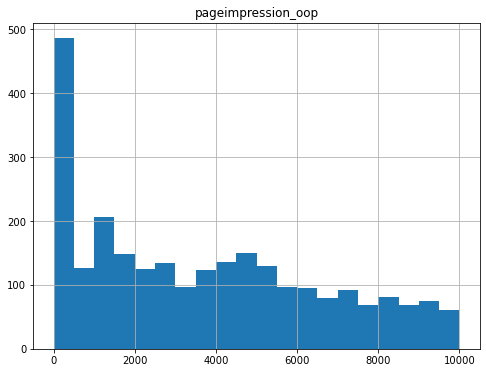

In [269]:
result.hist(column='pageimpression_oop', range=[1,10000],bins=20)

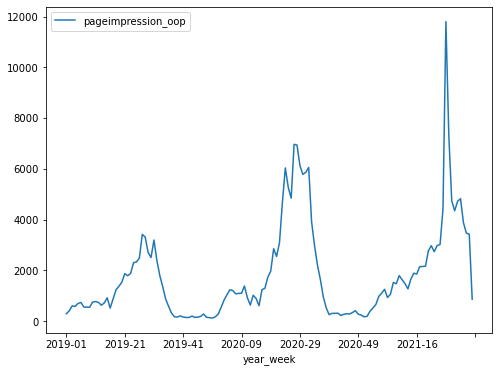

In [273]:
subset=result[(result.sub_category_name_de=="Schulbedarf")]
subset.plot( 'year_week' , 'pageimpression_oop' )
y=subset[['year_week','pageimpression_oop']].set_index("year_week")
#y=subset[['date','pageimpression_oop']].set_index("date").to_period("M")

In [274]:
y.count()

pageimpression_oop    140
dtype: int64

In [278]:
# Split Train & Test Data
y_train=y[:len(y)-35]
y_test=y[len(y)-35:]


<AxesSubplot:xlabel='year_week'>

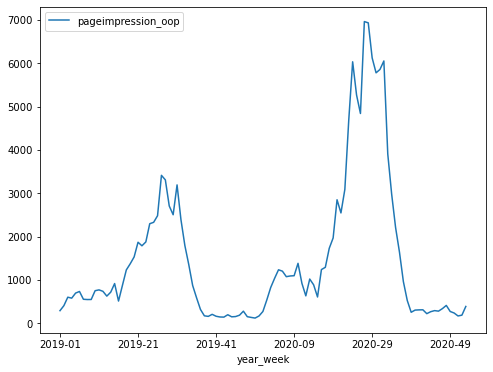

In [279]:
y_train.plot()

In [280]:
y_test

,pageimpression_oop
year_week,
2021-01,512.0
2021-02,650.0
2021-03,970.0
2021-04,1099.0
2021-05,1252.0
2021-06,926.0
2021-07,1053.0
2021-08,1518.0
2021-09,1472.0


In [305]:
y_train.count()

pageimpression_oop    105
dtype: int64

In [281]:
train_mean = y_train.mean()
train_std = y_train.std()

y_train = (y_train - train_mean) / train_std
#val_df = (val_df - train_mean) / train_std
y_test = (y_test - train_mean) / train_std

In [414]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=y_train, val_df=y_test, test_df=y_test,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [415]:
import numpy as np
w2 = WindowGenerator(input_width=3, label_width=1, shift=1,
                     label_columns=['pageimpression_oop'])
w2

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['pageimpression_oop']

In [416]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [417]:
w2.total_window_size

4

In [418]:
# Stack three slices, the length of the total window.
import tensorflow as tf
example_window = tf.stack([np.array(y_train[:w2.total_window_size])
                           #np.array(y_train[3:3+w2.total_window_size]),
                           #np.array(y_train[6:6+w2.total_window_size])
                          ])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (1, 4, 1)
Inputs shape: (1, 3, 1)
Labels shape: (1, 1, 1)


In [419]:
y_train

,pageimpression_oop
year_week,
2019-01,-0.707798
2019-02,-0.639211
2019-03,-0.523914
2019-04,-0.536922
2019-05,-0.467743
...,...
2020-49,-0.719032
2020-50,-0.739726
2020-51,-0.779933


In [420]:
example_inputs

<tf.Tensor: shape=(1, 3, 1), dtype=float64, numpy=
array([[[-0.70779799],
        [-0.63921095],
        [-0.52391377]]])>

In [421]:
example_labels

<tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[-0.53692166]]])>

In [422]:
y_train[:w2.total_window_size]

,pageimpression_oop
year_week,
2019-01,-0.707798
2019-02,-0.639211
2019-03,-0.523914
2019-04,-0.536922


In [423]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [424]:
def plot(self, model=None, plot_col='pageimpression_oop', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [Y-M]')

WindowGenerator.plot = plot

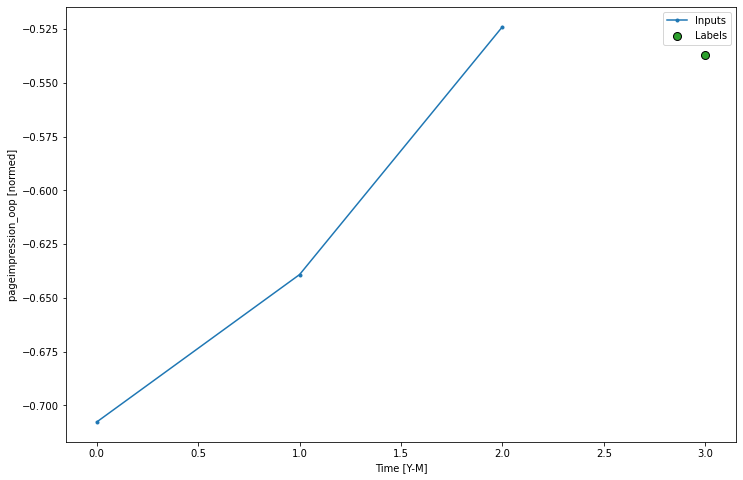

In [425]:
w2.example = example_inputs, example_labels
w2.plot()

In [426]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [427]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [428]:
w2.train.element_spec

(TensorSpec(shape=(None, 3, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [429]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 3, 1)
Labels shape (batch, time, features): (32, 1, 1)


In [430]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['pageimpression_oop'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['pageimpression_oop']

In [300]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 1)
Labels shape (batch, time, features): (32, 1, 1)


In [431]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [432]:
column_indices = {name: i for i, name in enumerate(y_train.columns)}

In [433]:
baseline = Baseline(label_index=column_indices['pageimpression_oop'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

2/2 [==============================] - 0s 2ms/step - loss: 0.9542 - mean_absolute_error: 0.4435


In [434]:
wide_window = WindowGenerator(
    input_width=104, label_width=104, shift=1,
    label_columns=['pageimpression_oop'])

wide_window

Total window size: 105
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103]
Label indices: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104]
Label column name(s): ['pageimpression_oop']

In [435]:
w2

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['pageimpression_oop']

In [436]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (1, 104, 1)
Output shape: (1, 104, 1)


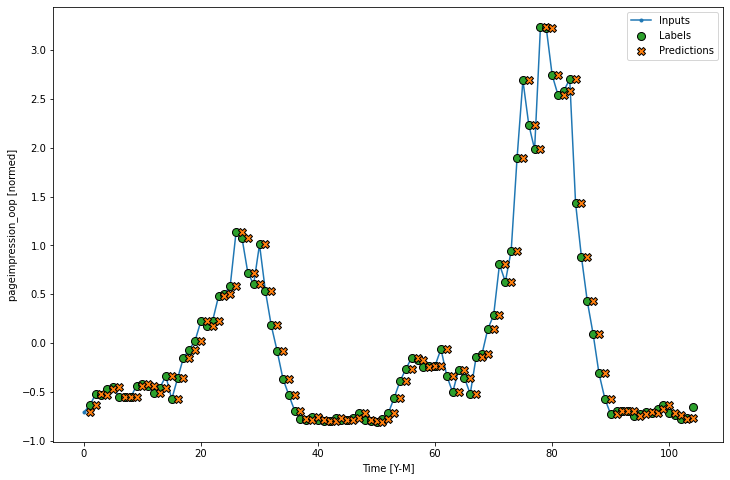

In [437]:
wide_window.plot(baseline)

In [451]:
#The simplest trainable model you can apply to this task is to insert linear transformation between the input and output. In this case the output from a time step only depends on that step:

linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=3)
])

In [452]:
print('Input shape:', w2.example[0].shape)
print('Output shape:', linear(w2.example[0]).shape)

Input shape: (32, 3, 1)
Output shape: (32, 3, 3)


In [457]:
MAX_EPOCHS = 20 #number of training cycles- stepwise fitting process, back propagation

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [458]:
history = compile_and_fit(linear, w2)

val_performance['Linear'] = linear.evaluate(w2.val)
performance['Linear'] = linear.evaluate(w2.test, verbose=0)

Epoch 1/20
4/4 [==============================] - 1s 51ms/step - loss: 1.7237 - mean_absolute_error: 0.8961 - val_loss: 3.7967 - val_mean_absolute_error: 1.1386
Epoch 2/20
4/4 [==============================] - 0s 22ms/step - loss: 1.7160 - mean_absolute_error: 0.8933 - val_loss: 3.7823 - val_mean_absolute_error: 1.1360
Epoch 3/20
4/4 [==============================] - 0s 23ms/step - loss: 1.7079 - mean_absolute_error: 0.8909 - val_loss: 3.7669 - val_mean_absolute_error: 1.1331
Epoch 4/20
4/4 [==============================] - 0s 23ms/step - loss: 1.6996 - mean_absolute_error: 0.8885 - val_loss: 3.7520 - val_mean_absolute_error: 1.1304
Epoch 5/20
4/4 [==============================] - 0s 23ms/step - loss: 1.6917 - mean_absolute_error: 0.8862 - val_loss: 3.7367 - val_mean_absolute_error: 1.1275
Epoch 6/20
4/4 [==============================] - 0s 23ms/step - loss: 1.6832 - mean_absolute_error: 0.8837 - val_loss: 3.7216 - val_mean_absolute_error: 1.1248
Epoch 7/20
4/4 [==================

In [459]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (1, 104, 1)
Output shape: (1, 104, 1)


In [460]:
linear.summary()

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_70 (Dense)             (None, None, 3)           6         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________


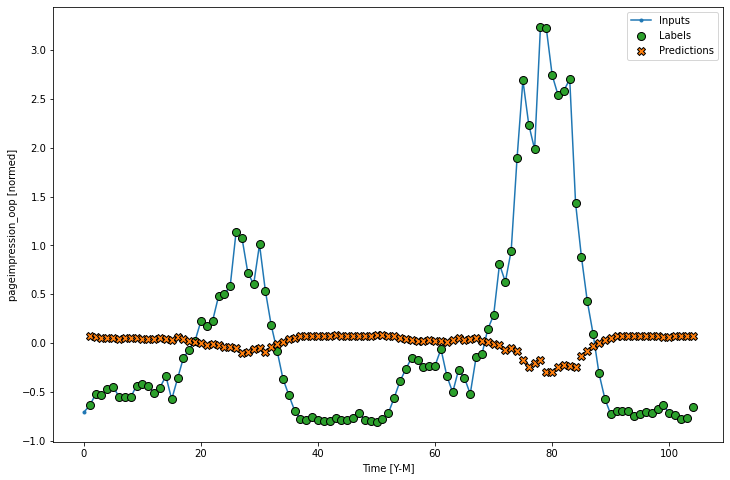

In [461]:
wide_window.plot(linear)

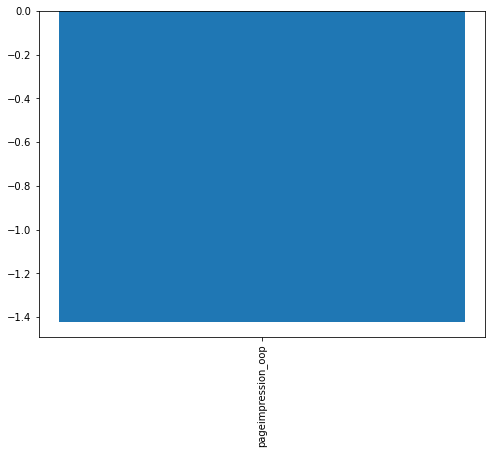

In [57]:
plt.bar(x = range(len(y_train.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(y_train.columns)))
_ = axis.set_xticklabels(y_train.columns, rotation=90)

In [114]:
w2.val

AttributeError: 'MapDataset' object has no attribute 'plot'

In [413]:
w2

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['pageimpression_oop']

In [462]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'), #how much model can adapt ??
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, w2)

val_performance['Dense'] = dense.evaluate(w2.val)
performance['Dense'] = dense.evaluate(w2.test, verbose=0)

Epoch 1/20
4/4 [==============================] - 2s 66ms/step - loss: 1.0270 - mean_absolute_error: 0.7669 - val_loss: 2.0731 - val_mean_absolute_error: 0.8652
Epoch 2/20
4/4 [==============================] - 0s 24ms/step - loss: 0.8127 - mean_absolute_error: 0.6804 - val_loss: 1.8118 - val_mean_absolute_error: 0.7792
Epoch 3/20
4/4 [==============================] - 0s 26ms/step - loss: 0.6727 - mean_absolute_error: 0.6107 - val_loss: 1.6102 - val_mean_absolute_error: 0.6990
Epoch 4/20
4/4 [==============================] - 0s 24ms/step - loss: 0.5398 - mean_absolute_error: 0.5435 - val_loss: 1.4684 - val_mean_absolute_error: 0.6454
Epoch 5/20
4/4 [==============================] - 0s 24ms/step - loss: 0.4445 - mean_absolute_error: 0.4897 - val_loss: 1.3585 - val_mean_absolute_error: 0.5941
Epoch 6/20
4/4 [==============================] - 0s 24ms/step - loss: 0.3550 - mean_absolute_error: 0.4333 - val_loss: 1.2949 - val_mean_absolute_error: 0.5559
Epoch 7/20
4/4 [==================

In [463]:
dense.summary()
#

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_71 (Dense)             (None, 3, 64)             128       
_________________________________________________________________
dense_72 (Dense)             (None, 3, 64)             4160      
_________________________________________________________________
dense_73 (Dense)             (None, 3, 1)              65        
Total params: 4,353
Trainable params: 4,353
Non-trainable params: 0
_________________________________________________________________


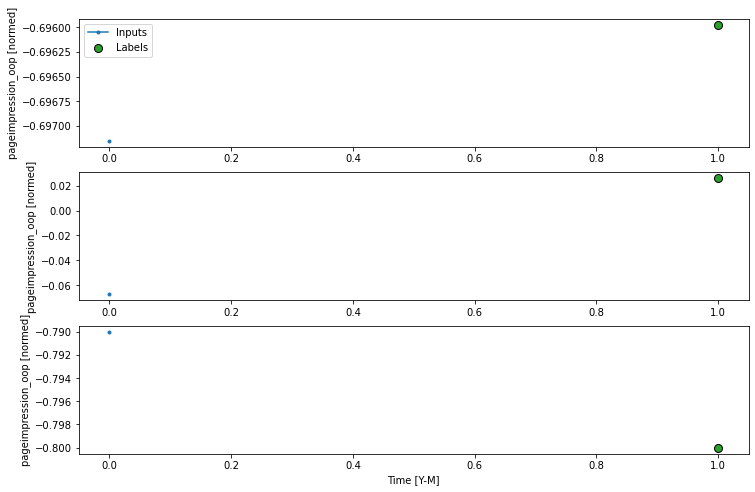

In [464]:
single_step_window.plot()

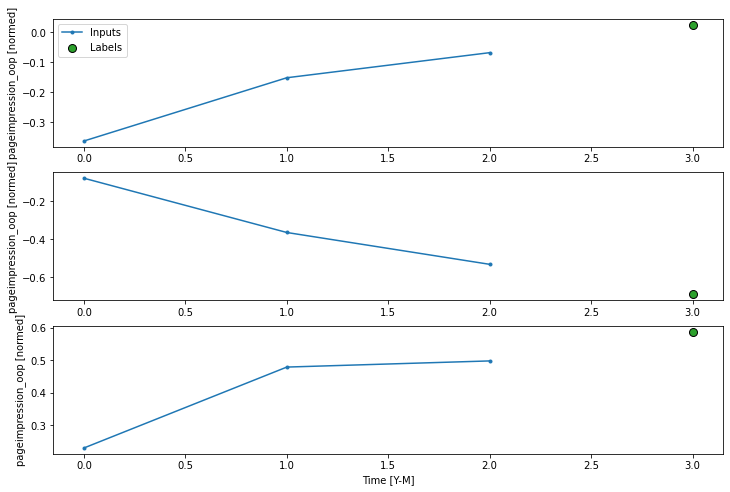

In [465]:
w2.plot()

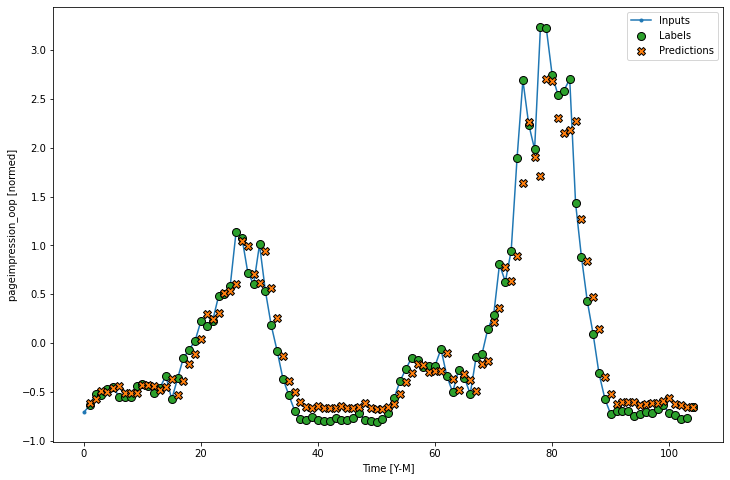

In [466]:
wide_window.plot(dense)

In [467]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['pageimpression_oop'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['pageimpression_oop']

Text(0.5, 1.0, 'Given 3 months of inputs, predict 1 month into the future.')

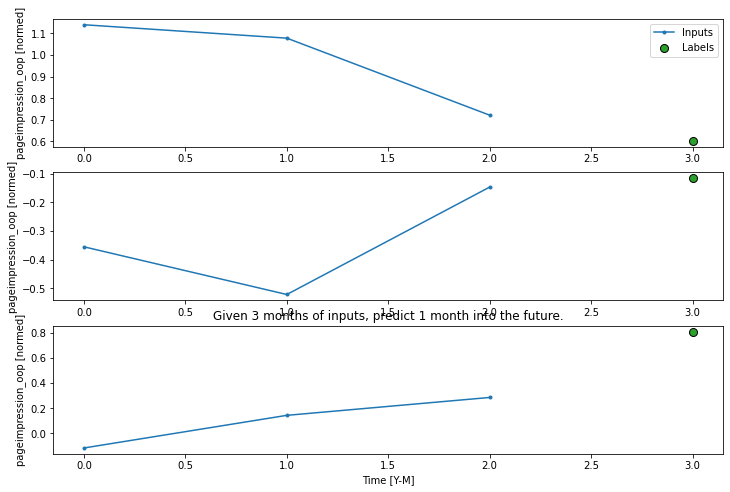

In [468]:
conv_window.plot()
plt.title("Given 3 months of inputs, predict 1 month into the future.")

In [469]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [470]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 1)
Output shape: (32, 1, 1)


In [471]:
import IPython
import IPython.display
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

1/1 [==============================] - 0s 68ms/step - loss: 0.9825 - mean_absolute_error: 0.4688


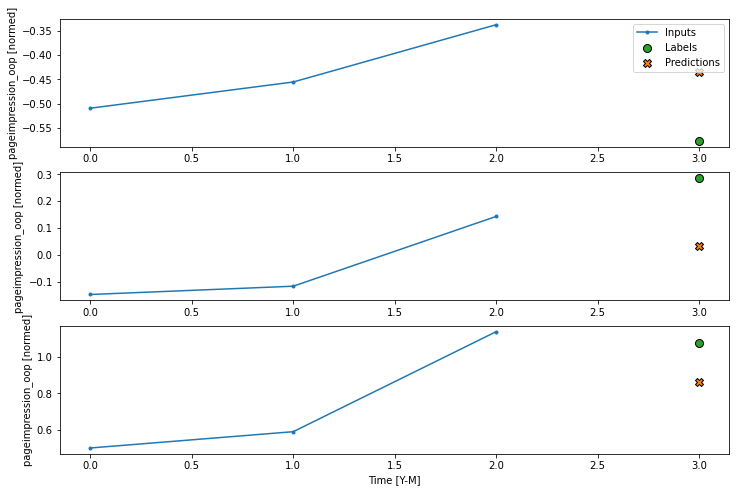

In [365]:
conv_window.plot(multi_step_dense)

In [472]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=54, activation='relu'),
    tf.keras.layers.Dense(units=1),
])
#

In [473]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 1)
Output shape: (32, 1, 1)


In [474]:
import IPython
import IPython.display
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

1/1 [==============================] - 0s 70ms/step - loss: 1.0998 - mean_absolute_error: 0.4668


In [475]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (1, 104, 1)
Labels shape: (1, 104, 1)
Output shape: (1, 102, 1)


In [476]:
LABEL_WIDTH = 102
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['pageimpression_oop'])

wide_conv_window

Total window size: 105
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103]
Label indices: [  3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20
  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56
  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74
  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 104]
Label column name(s): ['pageimpression_oop']

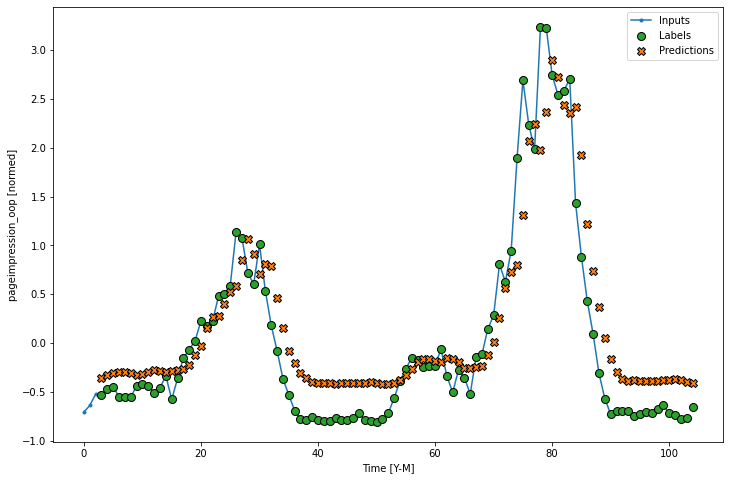

In [477]:
wide_conv_window.plot(conv_model)

In [485]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(1, return_sequences=True,activation='relu'),
    #tf.keras.layers.LSTM(1, return_sequences=True,activation='relu'),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [486]:
print('Input shape:', w2.example[0].shape)
print('Output shape:', lstm_model(w2.example[0]).shape)

Input shape: (32, 6, 1)
Output shape: (32, 6, 1)


In [487]:
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['pageimpression_oop']

In [488]:
history = compile_and_fit(lstm_model, w2)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(w2.val)
performance['LSTM'] = lstm_model.evaluate(w2.test, verbose=0)

1/1 [==============================] - 0s 68ms/step - loss: 2.5685 - mean_absolute_error: 1.0078


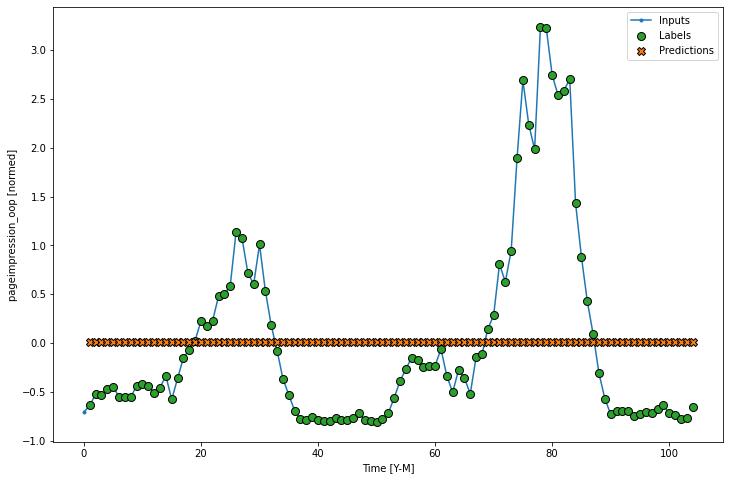

In [489]:
wide_window.plot(lstm_model)

In [483]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['pageimpression_oop'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['pageimpression_oop']

1/1 [==============================] - 0s 91ms/step - loss: 2.6047 - mean_absolute_error: 1.0252


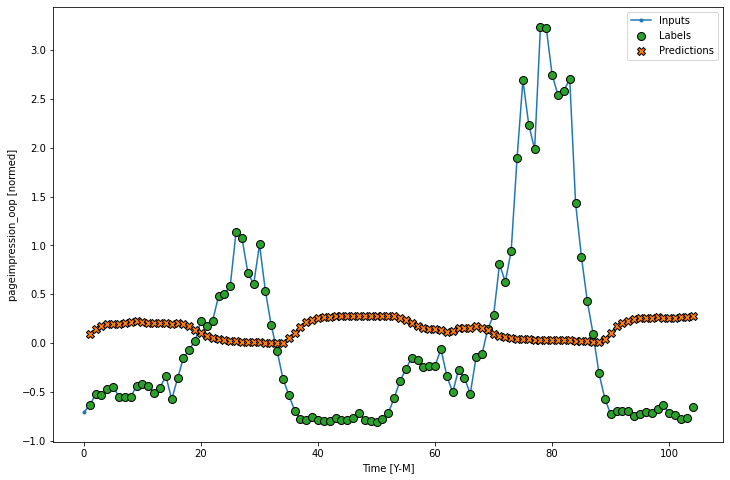

In [484]:
history = compile_and_fit(lstm_model, w2)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(w2.val)
performance['LSTM'] = lstm_model.evaluate(w2.test, verbose=0)
wide_window.plot(lstm_model)

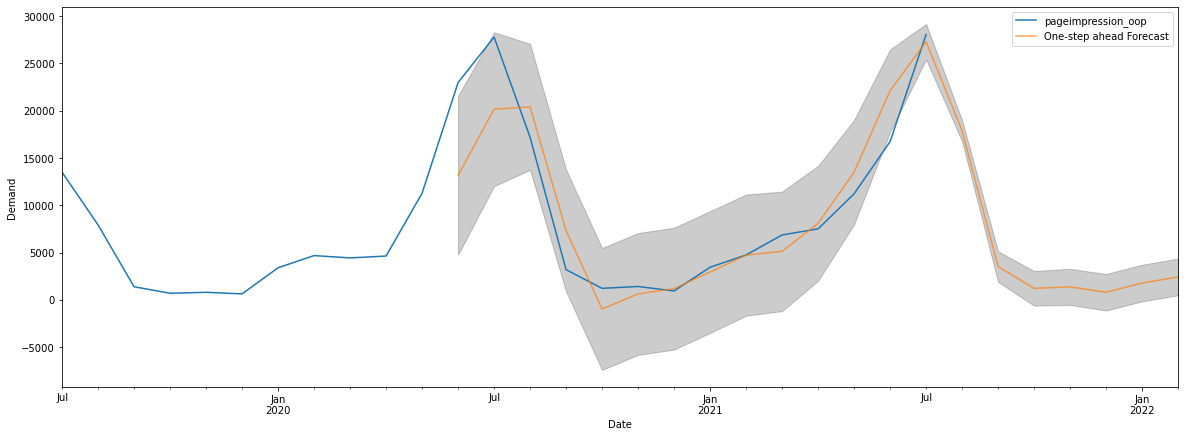

2020-06    13168.282365
2020-07    20157.356140
2020-08    20402.526697
2020-09     7321.185683
2020-10     -956.126081
2020-11      632.108036
2020-12     1188.941922
2021-01     2948.757562
2021-02     4733.440042
2021-03     5135.103512
2021-04     8094.918337
2021-05    13497.757991
2021-06    22110.658879
2021-07    27291.468997
2021-08    17873.870783
2021-09     3523.001129
2021-10     1225.712931
2021-11     1375.863458
2021-12      810.021636
2022-01     1783.802979
2022-02     2427.845822
Freq: M, Name: predicted_mean, dtype: float64

In [62]:
pred = results.get_prediction(start=pd.to_datetime('2020-06-01'), end=pd.to_datetime('2022-02-01'),dynamic=False)
pred_ci = pred.conf_int()
ax = y_train.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(20,7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Demand')
pyplot.legend()
pyplot.show()
pred.predicted_mean

In [63]:
#errors in prediction
import numpy as np
from sklearn.metrics import mean_squared_error
y_forecasted = pred.predicted_mean.to_frame()
y_truth = y_test['2021-05-01':]
y_forecasted = y_forecasted['2021-05-01':].rename(columns={"predicted_mean": "value"})
y_forecasted=y_forecasted[0:1].round()
y_truth = y_truth.rename(columns={"pageimpression_oop": "value"})
mse=mean_squared_error(y_truth['value'],y_forecasted['value'])
mpe=mean_absolute_percentage_error(y_truth['value'],y_forecasted['value'])
mse2 = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))
#print('The Mean Squared Error is {}'.format(round(mpe, 2)))
print('The Root Mean Percentage Squared Error is {}'.format(mpe,2))

The Mean Squared Error is 14691889.0
The Root Mean Squared Error is 3833.0
The Root Mean Percentage Squared Error is 0.22116438751370376


In [54]:
y_forecasted[0:1].round()

,value
2021-08,17874.0


In [55]:
y_truth

,value
date,
2021-08,17331.0


NameError: name 'plt' is not defined

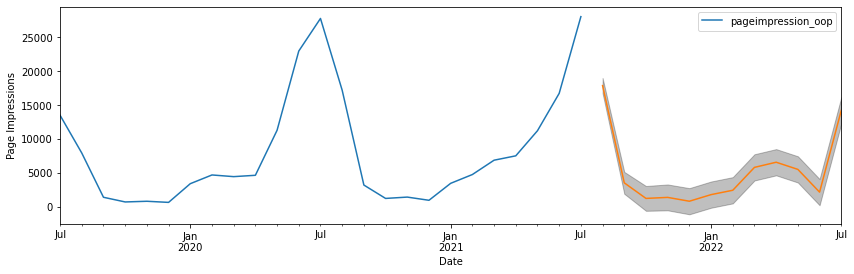

In [56]:
pred_uc = results.get_forecast(steps=12)
pred_ci = pred_uc.conf_int()
ax = y_train.plot(label='observed', figsize=(14, 4))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Page Impressions')
plt.legend()
plt.show()

In [57]:
y_forecasted = pred.predicted_mean
y_forecasted.head(12)

2021-01     2948.757562
2021-02     4733.440042
2021-03     5135.103512
2021-04     8094.918337
2021-05    13497.757991
2021-06    22110.658879
2021-07    27291.468997
2021-08    17873.870783
2021-09     3523.001129
2021-10     1225.712931
2021-11     1375.863458
2021-12      810.021636
Freq: M, Name: predicted_mean, dtype: float64

In [58]:
y_truth.head(12)

,value
date,
2021-08,17331.0


In [59]:
pred_ci.head(24)

,lower pageimpression_oop,upper pageimpression_oop
2021-08,16752.403665,18995.337901
2021-09,1906.685544,5139.316714
2021-10,-605.971113,3057.396975
2021-11,-533.423457,3285.150374
2021-12,-1121.570940,2741.614212
2022-01,-152.466948,3720.072906
2022-02,491.064099,4364.627544
2022-03,3869.680745,7743.141024
2022-04,4628.286784,8501.726871
2022-05,3570.995641,7444.487908


In [60]:
forecast = pred_uc.predicted_mean
forecast.head(12)
forecast.round()

2021-08    17874.0
2021-09     3523.0
2021-10     1226.0
2021-11     1376.0
2021-12      810.0
2022-01     1784.0
2022-02     2428.0
2022-03     5806.0
2022-04     6565.0
2022-05     5508.0
2022-06     2152.0
2022-07    14209.0
Freq: M, Name: predicted_mean, dtype: float64